In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import torch

import matplotlib.pyplot as plt

from dlp.dataset import Dataset

from parksim.intent_predict.cnn.data_processing.utils import CNNDataProcessor
from parksim.trajectory_predict.data_processing.utils import TransformerDataProcessor

from parksim.intent_predict.cnn.models.small_regularized_cnn import SmallRegularizedCNN
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_vision_transformer import TrajectoryPredictorVisionTransformer
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_with_decoder_intent_cross_attention import TrajectoryPredictorWithDecoderIntentCrossAttention

from parksim.trajectory_predict.intent_transformer.multimodal_prediction import predict_multimodal

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
ds = Dataset()

home_path = str(Path.home()) 
ds.load(home_path + '/dlp-dataset/data/DJI_0004')

In [3]:
MODEL_PATH = '/root/SUSTC_Parking_test/ParkSim/data/epoch=52-val_total_loss=0.0458.ckpt'
traj_model = TrajectoryPredictorWithDecoderIntentCrossAttention.load_from_checkpoint(MODEL_PATH)
traj_model.eval().to(DEVICE)
mode='v1'

INTENT_MODEL_PATH = '/root/SUSTC_Parking_test/ParkSim/data/smallRegularizedCNN_L0.068_01-29-2022_19-50-35.pth'
intent_model = SmallRegularizedCNN()
model_state = torch.load(INTENT_MODEL_PATH, map_location=DEVICE)
intent_model.load_state_dict(model_state)
intent_model.eval().to(DEVICE)

SmallRegularizedCNN(
  (image_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(

In [4]:
intent_extractor = CNNDataProcessor(ds=ds)
traj_extractor = TransformerDataProcessor(ds=ds)

In [5]:
def draw_prediction(multimodal_prediction, inst_centric_view, colors, intent_offsets):
    sensing_limit = 20
    img_size = inst_centric_view.size[0] / 2

    plt.cla()

    plt.imshow(inst_centric_view)

    y_label, _, _, _ = multimodal_prediction[0]

    traj_future_pixel = y_label[0, :, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    plt.plot(traj_future_pixel[:, 0], traj_future_pixel[:, 1], 'wo', linewidth=2, markersize=2)

    for prediction, color, offset in zip(reversed(multimodal_prediction), reversed(colors), reversed(intent_offsets)):

        _, pred, intent, probability = prediction

        intent_pixel = intent[0, 0, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        traj_pred_pixel = pred[0, :, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        plt.plot(traj_pred_pixel[:, 0], traj_pred_pixel[:, 1],
                 '^', color=color, linewidth=2, markersize=2)
        plt.plot(intent_pixel[0], intent_pixel[1],
                 '*', color=color, markersize=8)

        plt.text(intent_pixel[0]+offset[0], intent_pixel[1]+offset[1],
                 f'{probability:.2f}', backgroundcolor=(170/255., 170/255., 170/255., 0.53), color='black', size=7, weight='bold')
        print(color, probability)
                 
    plt.axis('off')


# Example 1

In [6]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 80
frame = ds.get_future_frames(scene['first_frame'],timesteps=300)[frame_index]
inst_token = frame['instances'][12]

In [7]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 1, mode=mode)

In [8]:
print((multimodal_prediction[0]))
print(multimodal_prediction[0][0].shape)

[tensor([[[ 5.1086e-01, -4.2252e-03, -6.0000e-03],
         [ 1.0417e+00, -7.4411e-03, -1.1900e-02],
         [ 1.6130e+00, -1.8626e-02, -1.9300e-02],
         [ 2.2038e+00, -1.8814e-02, -2.7900e-02],
         [ 2.8155e+00, -3.7967e-02, -4.1000e-02],
         [ 3.4173e+00, -5.7625e-02, -5.7700e-02],
         [ 3.9901e+00, -9.8772e-02, -7.8600e-02],
         [ 4.5429e+00, -1.4093e-01, -1.0220e-01],
         [ 5.0763e+00, -1.9408e-01, -1.2740e-01],
         [ 5.5907e+00, -2.6822e-01, -1.5610e-01]]], device='cuda:0'), tensor([[[ 0.4909, -0.0052, -0.0054],
         [ 0.8620,  0.0282,  0.0119],
         [ 1.2566,  0.0815,  0.0358],
         [ 1.6512,  0.1520,  0.0640],
         [ 2.0321,  0.2376,  0.0951],
         [ 2.3795,  0.3360,  0.1280],
         [ 2.6848,  0.4444,  0.1616],
         [ 2.9381,  0.5584,  0.1948],
         [ 3.1348,  0.6730,  0.2266],
         [ 3.2759,  0.7836,  0.2565]]], device='cuda:0'), tensor([[[19.1022,  3.5185]]], device='cuda:0'), 0.4843011498451233]
torch.Size

green 0.4843011498451233


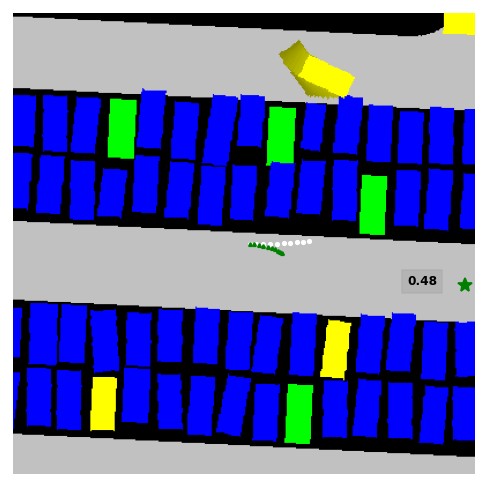

In [9]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50,0], [0,30], [-50,0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 2

In [10]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 2500
frame = ds.get_future_frames(scene['first_frame'], timesteps=2700)[frame_index]
inst_token = frame['instances'][7]


In [11]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.12679365
C1 0.14712243278821308
darkviolet 0.2648203790187836


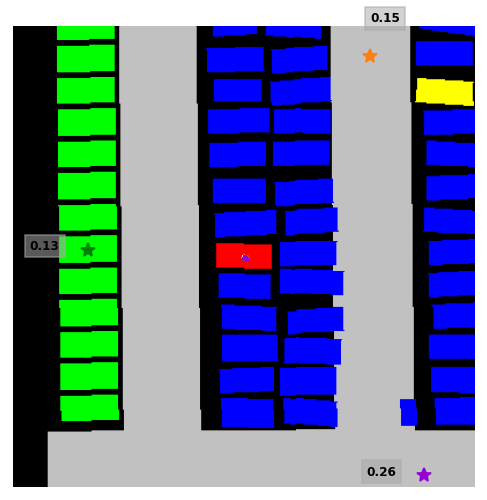

In [12]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 3

In [13]:
# scene = ds.get('scene', ds.list_scenes()[0])
# frame_index = 5900
# frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
# inst_token = frame['instances'][37]

scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 5900
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][10]


In [14]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.103481
C1 0.16787098
darkviolet 0.3387120634317398


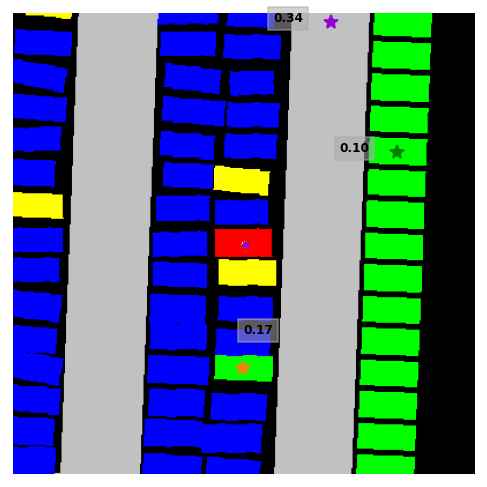

In [15]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 4

In [16]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 4000
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][10]


In [17]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.08027982
C1 0.20608653624852497
darkviolet 0.37095576524734497


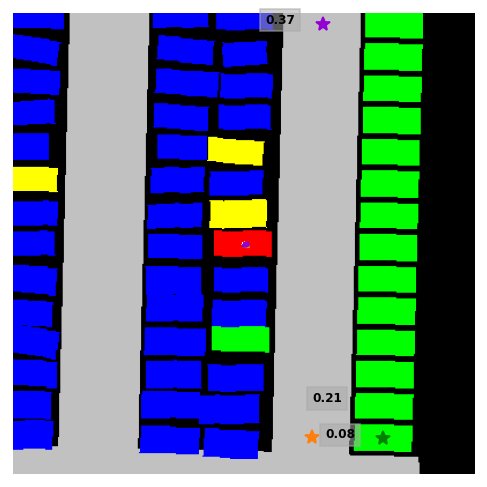

In [18]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 5

In [40]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 100
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][2]


In [41]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode, is_get_trajectory_future=False)


green 0.06666666666666667
C1 0.3333333333333333
darkviolet 0.6


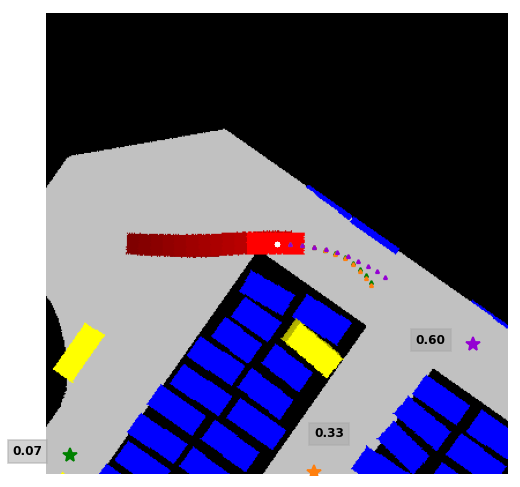

In [42]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 6

In [22]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 1800
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[70, 30])[
    'instance_token']


In [23]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.081707835
C1 0.19045477
darkviolet 0.6550535917282104


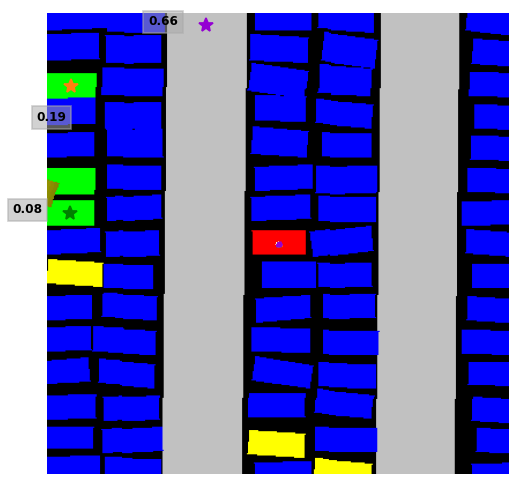

In [24]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, 30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 7

In [25]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 7010
frame = ds.get_future_frames(scene['first_frame'], timesteps=7100)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[15, 30])[
    'instance_token']


In [26]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.090407625
C1 0.209877610206604
darkviolet 0.3777796983718872


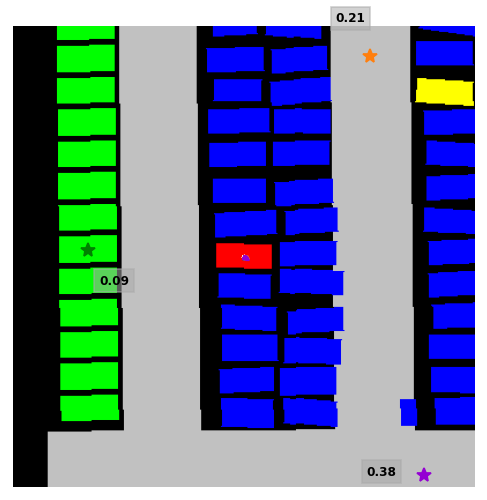

In [27]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -30], [10, 30]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 8

In [28]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 9000
frame = ds.get_future_frames(scene['first_frame'], timesteps=9001)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[35, 65])[
    'instance_token']


In [29]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.1
C1 0.9


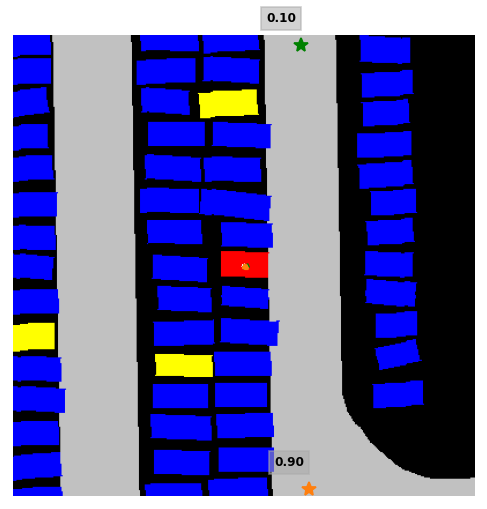

In [30]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -20], [-30, -20]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)
